# check eventdet oof df

In [19]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [20]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [21]:
output_dir = os.path.join("/kaggle", "working", "_oof")
# exp_name = "event_det_debug"
exp_name = "debug_secondstg"
print("load oof df")
oof_df = pd.DataFrame()
# for i in range(5):
for i in range(1):
    print("fold", i)
    df = pd.read_parquet(os.path.join(output_dir, exp_name, f"oof_df_fold{i}.parquet"))
    for col in df.columns:
        # 64bit float -> 16bit float
        if df[col].dtype == np.float64:
            df[col] = df[col].astype(np.float16)
        # 64bit int -> 16bit int
        elif df[col].dtype == np.int64:
            df[col] = df[col].astype(np.int16)

    oof_df = pd.concat([oof_df, df], axis=0)

load oof df
fold 0


In [22]:
oof_df.columns

Index(['series_id', 'step', 'anglez', 'enmo', 'event', 'event_onset',
       'event_wakeup', 'date', 'series_date_key', 'series_date_key_str',
       'fold', 'class_pred', 'event_pred', 'event_target', 'onset_pred',
       'wakeup_pred', 'onset_target', 'wakeup_target'],
      dtype='object')

In [23]:
train_event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_event_df = train_event_df[train_event_df["series_id"].isin(oof_df["series_id"].unique())].copy()
train_event_df = train_event_df.reset_index(drop=True)
display(train_event_df.head())

,series_id,night,event,step,timestamp
0,0ec9fc461819,1,onset,6108.0,2019-03-27T22:29:00-0400
1,0ec9fc461819,1,wakeup,12060.0,2019-03-28T06:45:00-0400
2,0ec9fc461819,2,onset,26412.0,2019-03-29T02:41:00-0400
3,0ec9fc461819,2,wakeup,29424.0,2019-03-29T06:52:00-0400
4,0ec9fc461819,3,onset,41412.0,2019-03-29T23:31:00-0400


In [24]:
import sys
sys.path.append("/kaggle/src/dss_utils")

from dss_metrics import score

In [25]:
event_df = train_event_df[train_event_df["step"].notnull()].copy()

In [26]:
series_id_list = oof_df["series_id"].unique()

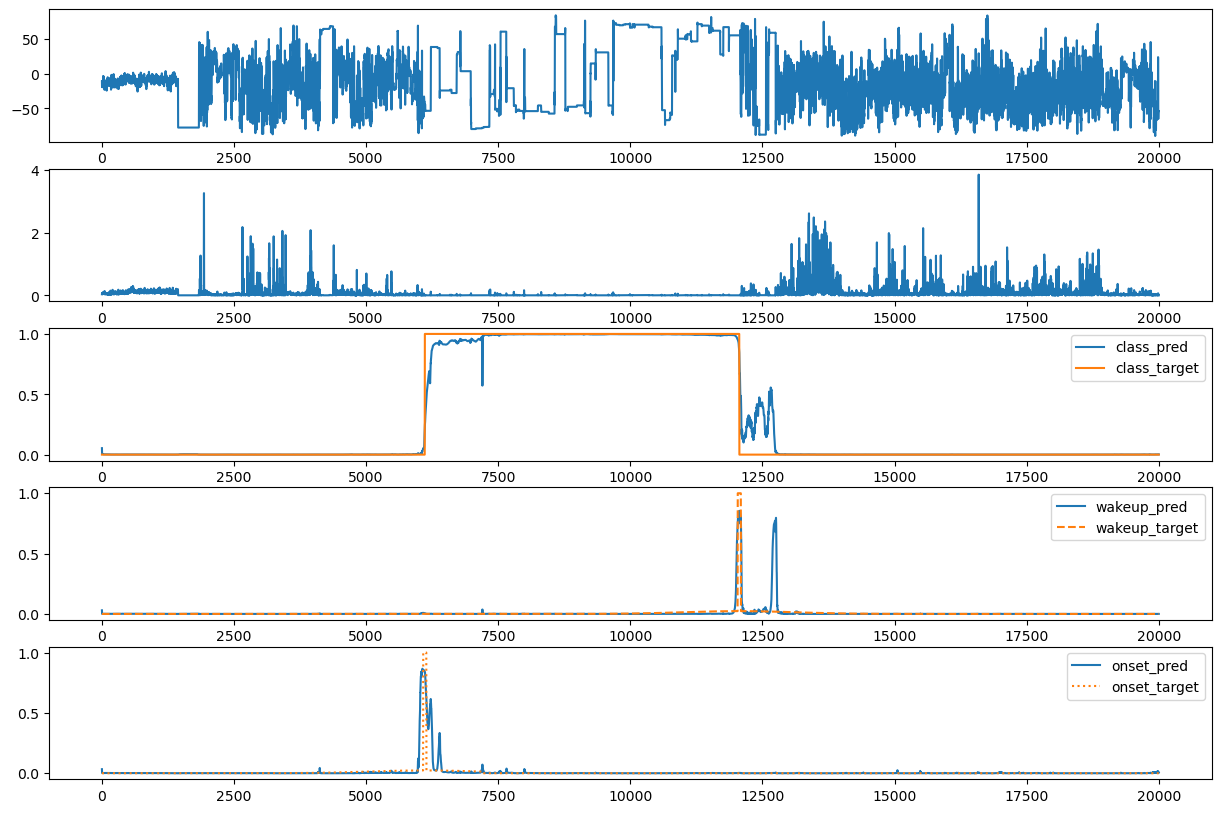

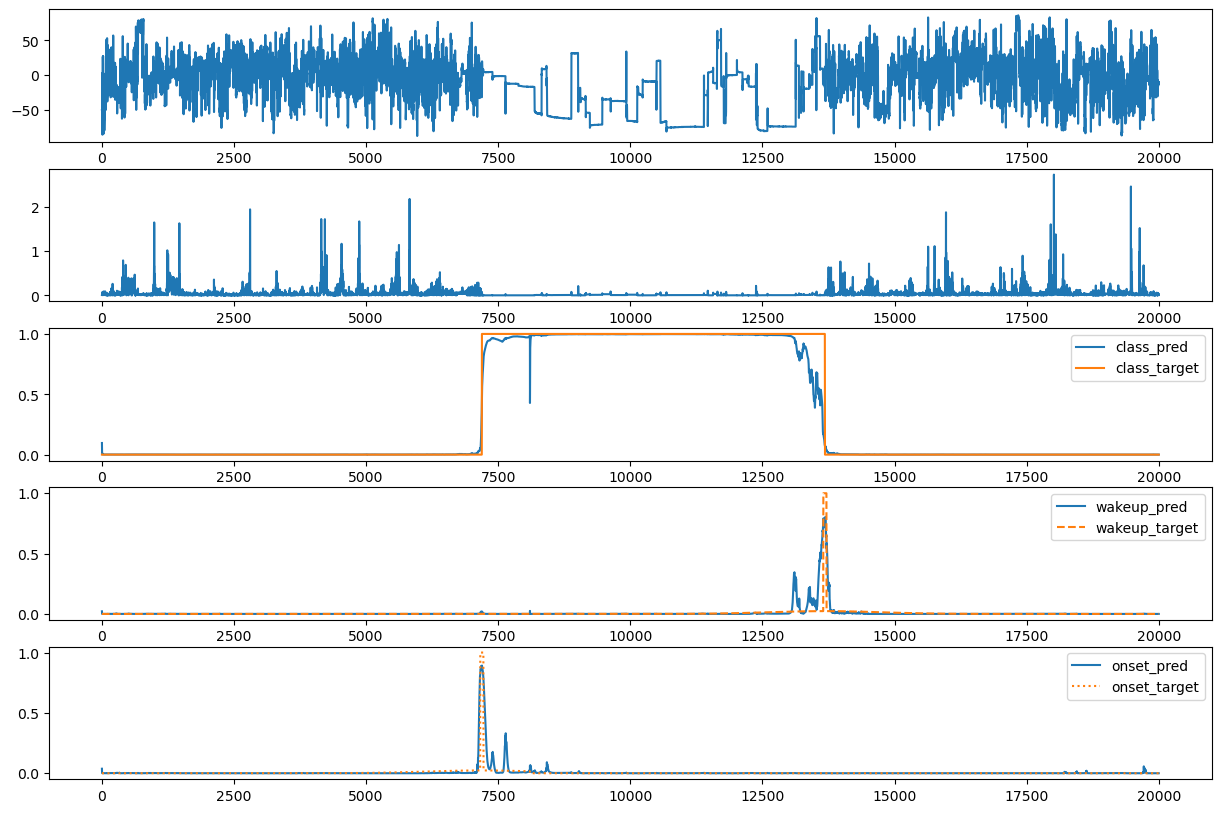

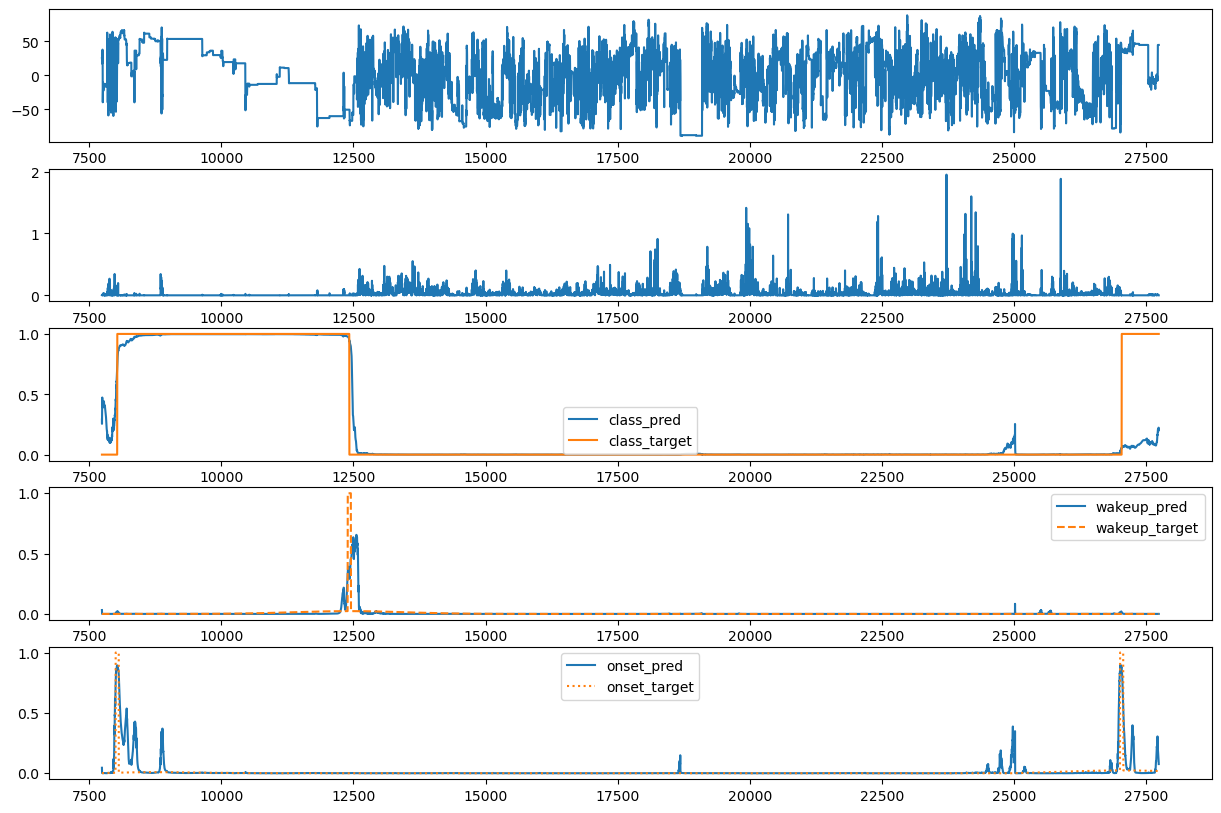

In [27]:
for idx, series_id in enumerate(series_id_list):
    if idx > 2:
        break
    df = oof_df[oof_df["series_id"] == series_id].copy()
    df = df.iloc[: 20000]
    plt.figure(figsize=(15, 10))
    plt.subplot(5, 1, 1)
    plt.plot(df["step"], df["anglez"], label="anglez")
    plt.subplot(5, 1, 2)
    plt.plot(df["step"], df["enmo"], label="enmo")
    plt.subplot(5, 1, 3)
    plt.plot(df["step"], df["class_pred"], label="class_pred")
    plt.plot(df["step"], df["event"], label="class_target")
    plt.legend()
    plt.subplot(5, 1, 4)
    plt.plot(df["step"], df["wakeup_pred"], label="wakeup_pred")
    plt.plot(df["step"], df["wakeup_target"], "--", label="wakeup_target")
    plt.legend()
    plt.subplot(5, 1, 5)
    plt.plot(df["step"], df["onset_pred"], label="onset_pred")
    plt.plot(df["step"], df["onset_target"], ":",label="onset_target")
    plt.legend()
    plt.show()

In [28]:
oof_df["step"] = oof_df["step"].astype(np.float64)

In [29]:
import torch
import torch.nn as nn

def make_submission_from_eventdf(df, threshold=0.1):
    df = df[["series_id", "step", "onset_pred", "wakeup_pred"]].copy()
    df["step"] = df["step"].astype(np.float64)
    max_pool = nn.MaxPool1d(11, stride=1, padding=5)
    onset_pred = max_pool(torch.tensor(df["onset_pred"].values).unsqueeze(0)).squeeze(0).numpy()
    wakeup_pred = max_pool(torch.tensor(df["wakeup_pred"].values).unsqueeze(0)).squeeze(0).numpy()
    peak_mask = (onset_pred == df["onset_pred"].values)
    df["onset_pred"] = peak_mask * df["onset_pred"].values
    peak_mask = (wakeup_pred == df["wakeup_pred"].values)
    df["wakeup_pred"] = peak_mask * df["wakeup_pred"].values    
    # onset_predが大きい場合-onset_predの値を入力し、wakeup_predが大きい場合wakeup_predの値を入力する
    df["event_pred"] = np.where(
        df["onset_pred"].values > df["wakeup_pred"].values,
        -df["onset_pred"].values,
        df["wakeup_pred"].values,
    )
    # event_predがthreshold以上の場合、wakeup_predが大きい場合はwakeup、onset_predが大きい場合はonsetとする
    df["event_score"] = df["event_pred"].apply(
        lambda x: 1 if x > threshold else -1 if x < -threshold else 0
    )
    df = df[df["event_score"] != 0].copy()
    df["event"] = df["event_score"].replace({1: "wakeup", -1: "onset"})
    df["score"] = df["event_pred"].apply(lambda x: np.clip(np.abs(x), 0.0, 1.0))
    df = df.drop(["event_pred", "onset_pred", "wakeup_pred", "event_score"], axis=1)
    return df

In [30]:
sub_df = make_submission_from_eventdf(oof_df, threshold=0.1)
print(len(oof_df), len(sub_df), len(sub_df) / len(oof_df)*100)

16330780 20664 0.12653406634588182


threshold 0.1: 25621300 87072 0.3398422406357211

In [31]:
event_series_df = event_df[event_df["series_id"].isin(oof_df["series_id"].unique())].copy()

In [32]:
score(event_series_df, sub_df)

0.2609323275555059

In [33]:
sub_df.head()

,series_id,step,event,score
5988,0ec9fc461819,5988.0,onset,0.122719
6044,0ec9fc461819,6044.0,onset,0.841880
6064,0ec9fc461819,6064.0,onset,0.866330
6072,0ec9fc461819,6072.0,onset,0.856973
6092,0ec9fc461819,6092.0,onset,0.854037


In [34]:
event_series_df.head()

,series_id,night,event,step,timestamp
0,0ec9fc461819,1,onset,6108.0,2019-03-27T22:29:00-0400
1,0ec9fc461819,1,wakeup,12060.0,2019-03-28T06:45:00-0400
2,0ec9fc461819,2,onset,26412.0,2019-03-29T02:41:00-0400
3,0ec9fc461819,2,wakeup,29424.0,2019-03-29T06:52:00-0400
4,0ec9fc461819,3,onset,41412.0,2019-03-29T23:31:00-0400


In [35]:
one_series_id = "0ec9fc461819"
df = sub_df[sub_df["series_id"] == one_series_id].copy()
event_ = event_series_df[event_series_df["series_id"] == one_series_id].copy()
print(score(event_, df))

0.5238112978727695


In [36]:
df[df["step"]< 6200]

,series_id,step,event,score
5988,0ec9fc461819,5988.0,onset,0.122719
6044,0ec9fc461819,6044.0,onset,0.841880
6064,0ec9fc461819,6064.0,onset,0.866330
6072,0ec9fc461819,6072.0,onset,0.856973
6092,0ec9fc461819,6092.0,onset,0.854037
